# Multi-sensor Assimilation in the Sentinel era
## J Gómez-Dans (NCEO&UCL)
### OPTIRAD project

With the launch of different Sentinel sensors, there is an interest in the consistent exploitation of the data, using the individual sensors as a **virtual constellation**. In other words, we should be able to **use the observations from different sensors to provide a consistent monitoring capability of the land surface**.

``eoldas_ng`` is a tool that allows for this. This notebook presents a simple **simulation study** that demonstrates the merging of data from Sentinel3/MSI, Sentinel3/SLSTR and ProbaV sensors. 

IPython notebooks mix text cells (like this one) and code cells (like the following one), which imports some required functionality.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from s2_example_funcs import *
%matplotlib inline

np.random.seed( 13373 )
plot_config()

/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In this example, we'll consider the following sensors:

1. Sentinel 2/MSI
2. Sentinel 3/OLCI
3. Sentinel 3/SLSTR (nadir view)
4. Proba V

Each sensor has got different spectral properties. We will assume also that S2/MSI and ProbaV both have a 10:30am equatorial overpass, and assume that the sensors on Sentinel3 have a 1:30pm overpass (this is just to vary the illumination angles etc.). In the following code cell, you can select what **subset of these sensors** you want to use for the data assimilation. Change the variable to be either ``True`` or ``False`` to switch sensors on and off from the assimilation:

In [2]:
do_s2msi = True
do_s3olci = True
do_s3slstr = True
do_proba = True

In the following code snippet, we will use the ``eoldas_ng`` library to define the state, and to select what parameters we want to retrieve. We will also define the temporal grid over which the parameters will be reported, which in this case is a daily estimate (this is done in variable **``state_grid``**. The parameters of the state we will be solving for are defined by **``state_config``**, and we will solve for ``cab`` (leaf chlorophyll concentration), ``lai`` (leaf area index) and ``cw`` (leaf equivalent water thickness), by setting these elements in **``state_config``** to ``VARIABLE``. Other parameters will be set to their default value. Refer to the comments in the code for more details.

We then use an off the shelf state definition from ``eoldas_ng``, in this case, a version of the state that uses the PROSAIL radiative transfer model. We also define some extra optimisation options.

In [3]:
from collections import OrderedDict
from eoldas_ng import *

# First, we define the state grid, which in this case will report the 
# state vector every day for a year (so from DoY 1 -> DoY 365).

state_grid = np.arange ( 1, 366 )

# The state_config needs to be an ordered dictionary, where the keys
# are stored in the order they are added to the dictionary
state_config = OrderedDict ()

state_config['n'] = FIXED       # A FIXED parameter is one that is set to the default value
state_config['cab'] = VARIABLE  # VARIABLE means that we want to infer this parameter
                                # for every location in the state grid
state_config['car'] = FIXED
state_config['cbrown'] = FIXED
state_config['cw'] = VARIABLE
state_config['cm'] = FIXED
state_config['lai'] = VARIABLE
state_config['ala'] = FIXED
state_config['bsoil'] = FIXED
state_config['psoil'] = FIXED   # There's also CONSTANT, where a single value is used for all
                                # locations in the state grid


# This optimisation options are typically just fixed in the code
# The control convergence of the function minimiser
optimisation_options = {'ftol': 1./10000, 'gtol':1e-12, 
                        'macor':300, 'maxiter':1500 }


# We used the provide standard PROSAIL configuration state
# This class sets boundaries, parameter names, transformations, etc. automatically.
# We just need to make the state object aware of the state configuration dictionary,
# the state grid, and in this case, the optimisation options.
state =  StandardStatePROSAIL ( state_config, state_grid, 
                               optimisation_options=optimisation_options )

# You can also change any bit of the state. In this case, we want to change the 
# default values of the parameters
state.default_values=OrderedDict(zip ( state_config.keys(), np.array([  2.10000000e+00,   5.99999993e+01,   
                                                                      7.21901308e+00,                                                                                                                                                   
         0.50000000,   1.75965470e-02,   2.00000004e-03,                                                                                                                                                   
         1.35981420e+00,   2.99999997e+01,   1.00000000e+00,                                                                                                                                                   
         3.00000000e-01])))

for k,v in state.default_values.iteritems():
    print k, "=>", v


Saving results to eoldas_retval_20150827_140039_tyche.pkl
n => 2.1
cab => 59.9999993
car => 7.21901308
cbrown => 0.5
cw => 0.017596547
cm => 0.00200000004
lai => 1.3598142
ala => 29.9999997
bsoil => 1.0
psoil => 0.3


### The synthetic observations

We can now create the land surface *true state*. For this, we will assume that only clhorophyll, lai and leaf water change with time, and that they do so following a double logistic function, albeit in each case with different parameters. Let's see how these parameter trajectories look like! Remember, you can change the parameters of the double logistic here, or even apply other functions to other parts of the state if you want to.

The following few cells will generate (and plot) the synthetic observations for the different sensors. Before we do that, we will recover the spectral properties of the different sensors (number of bands, band pass functions, etc). These are defined in ``spectral_configuration``. 

As well as simulating the **directional surface reflectance**, adding noise and simulating cloud cover, we will also define the ``eoldas_ng`` **observation operator** objects for each observational stream. These also require gathering a number of *PROSAIL emulators* which are already in the system, as well as putting together a simple mask.

If you want to change the properties of each sensor, you can affect some of its parameters by changing e.g. the latitude and longitude, the overpass time, the frequency (**``every``** keyword, in days), the proportion of days that are not affected by cloud (**``propr``**), the mean gap between cloudy days (**``WINDOW``**), and the amount of noise (noise is assumed to be gaussian and independent, with a linear scaling as wavelength increases. This scalar basically scales this noise line up or down).

In [4]:
# First, load the waveband definitions for the different sensors:
s2_bh,s2_n_bands, s2_b_min, s2_b_max, s2_band_pass, \
        proba_bh, proba_n_bands, proba_b_min, proba_b_max, proba_band_pass, \
        slstr_bh, slstr_n_bands, slstr_b_min, slstr_b_max, slstr_band_pass, \
        olci_bh, olci_n_bands, olci_b_min, olci_b_max, olci_band_pass = spectral_configuration()

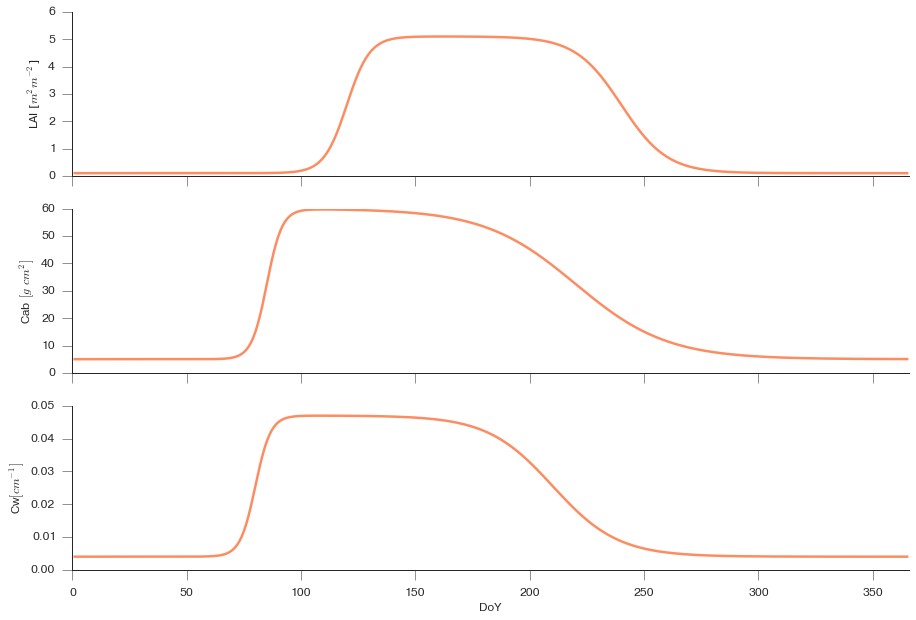

In [5]:
do_obs = True
emu_dir = "./emus/"
if do_obs:
    trajectories = {
        'lai': lambda t: dbl_logistic_model( [0.1, 5, -0.2, 120, 0.1, 240], t),     
        'cab': lambda t: dbl_logistic_model( [5, 55, -0.3, 85, 0.05, 220], t), 
        'cw': lambda t: dbl_logistic_model( [0.004, 0.043, -0.3, 80, 0.07, 210], t)

    }
    # Now, create some simulated data...
    parameter_grid = create_parameter_trajectories ( state, trajectories )

    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,10) )
    axs[0].plot ( np.arange(1, 366), parameter_grid[6, :], lw=2.5 )
    axs[0].set_ylabel ("LAI [$m^{2}m^{-2}$]")
    pretty_axes(axs[0])
    axs[1].plot ( np.arange(1, 366), parameter_grid[1, :], lw=2.5 )
    axs[1].set_ylabel ("Cab $[g\,cm^{2}]$")
    pretty_axes(axs[1])
    axs[2].plot ( np.arange(1, 366), parameter_grid[4, :], lw=2.5 )
    axs[2].set_xlabel( "DoY" )
    axs[2].set_ylabel ("Cw$[cm^{-1}]$")
    axs[2].set_xlim(0, 366)
    pretty_axes(axs[2])
    fig.savefig("Parameter_trajectories.pdf", dpi=600, bbox_inches="tight")
    np.savetxt ("parameter_trajectory.txt", parameter_grid.T, fmt="%20.8G")

(45, 5) (12, 45)
45 (12, 45)


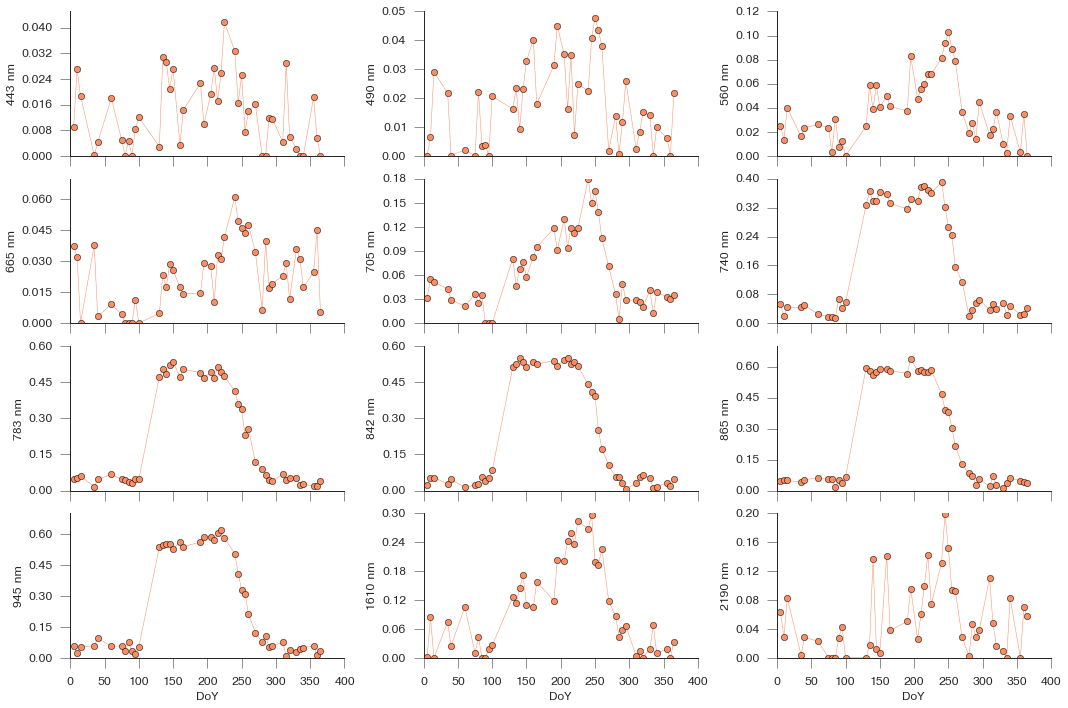

In [6]:
# Create S2/MSI observations, if considering this sensor
# Assume only one platform, so revisit pass of 10 days
if do_obs and do_s2msi:
    s2_doys, s2_vza, s2_sza, s2_raa, s2_rho, s2_bu = create_observations2 ( state,
                parameter_grid, "42.0", "-8:0", the_time="10:30", b_min=s2_b_min, 
                b_max = s2_b_max, every=5, prop=0.65, WINDOW=12, noise_scalar=1, 
                                                                           vza_var=7., 
                                                                           emu_dir=emu_dir )
    np.savetxt("s2_observations.txt", np.c_[ s2_doys, s2_vza, s2_sza, 
                                                 s2_raa, s2_rho.T],fmt="%20.10G")
    fig, axs = plt.subplots ( nrows=4, ncols=3, sharex=True, figsize=(15,10))
    axs = axs.flatten()
    for iband in xrange ( s2_n_bands ):

        axs[iband].plot ( s2_doys, s2_rho[iband, :], '-o', lw=0.5 )
        axs[iband].set_ylabel("%g nm" % s2_bh[iband])
        pretty_axes(axs[iband])
        if iband > 8:
            axs[iband].set_xlabel( "DoY")
    plt.tight_layout()
    s2_emulators = grab_emulators ( s2_vza, s2_sza, emulator_home=emu_dir)
    s2_mask = np.c_[ s2_doys, np.ones_like(s2_doys), s2_vza, s2_sza, 
                    np.zeros_like ( s2_sza)]
    print s2_mask.shape, s2_rho.shape
    s2_obs = ObservationOperatorNew( state_grid, state, s2_rho, s2_mask, \
                                    s2_emulators, s2_bu, s2_band_pass, 
                                    s2_b_max - s2_b_min )

98 (5, 98)


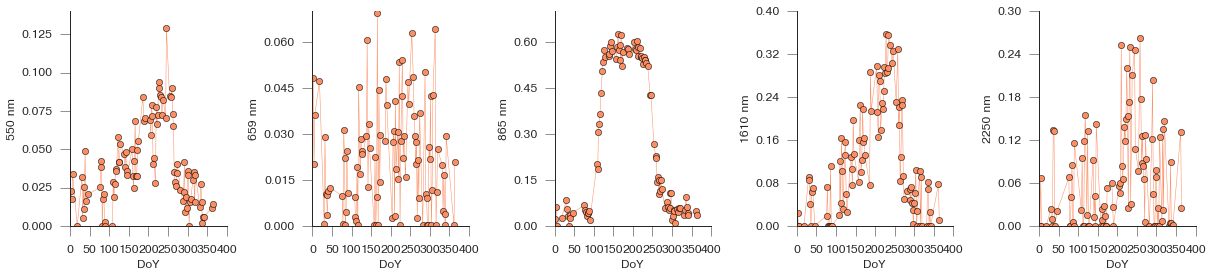

In [7]:
if do_obs and do_s3slstr:
    slstr_doys, slstr_vza, slstr_sza, slstr_raa, slstr_rho, slstr_bu = create_observations2 ( 
                state, parameter_grid, "42.0", "-8:0", the_time="10:00", b_min=slstr_b_min, 
                b_max = slstr_b_max, every=2, prop=0.55, WINDOW=10, noise_scalar=1.5, vza_var=0., emu_dir="./emus/" )
    np.savetxt("slstr_observations.txt", np.c_[ slstr_doys, slstr_vza, slstr_sza, 
                                                 slstr_raa, slstr_rho.T],fmt="%20.10G")

    fig, axs = plt.subplots ( nrows=1, ncols=5, sharex=True, figsize=(17,4))
    axs = axs.flatten()
    for iband in xrange ( slstr_n_bands ):

        axs[iband].plot ( slstr_doys, slstr_rho[iband, :], '-o', lw=0.5 )
        axs[iband].set_ylabel("%g nm" % slstr_bh[iband])
        pretty_axes(axs[iband])
        axs[iband].set_xlabel( "DoY")
    plt.tight_layout()
    slstr_emulators = grab_emulators ( slstr_vza, slstr_sza, emulator_home=emu_dir )
    slstr_mask = np.c_[ slstr_doys, np.ones_like(slstr_doys), slstr_vza, slstr_sza, \
                       np.zeros_like ( slstr_sza)]
    slstr_obs = ObservationOperatorNew( state_grid, state, slstr_rho, slstr_mask, \
                                    slstr_emulators, slstr_bu, slstr_band_pass, \
                                    slstr_b_max - slstr_b_min )

48 (15, 48)


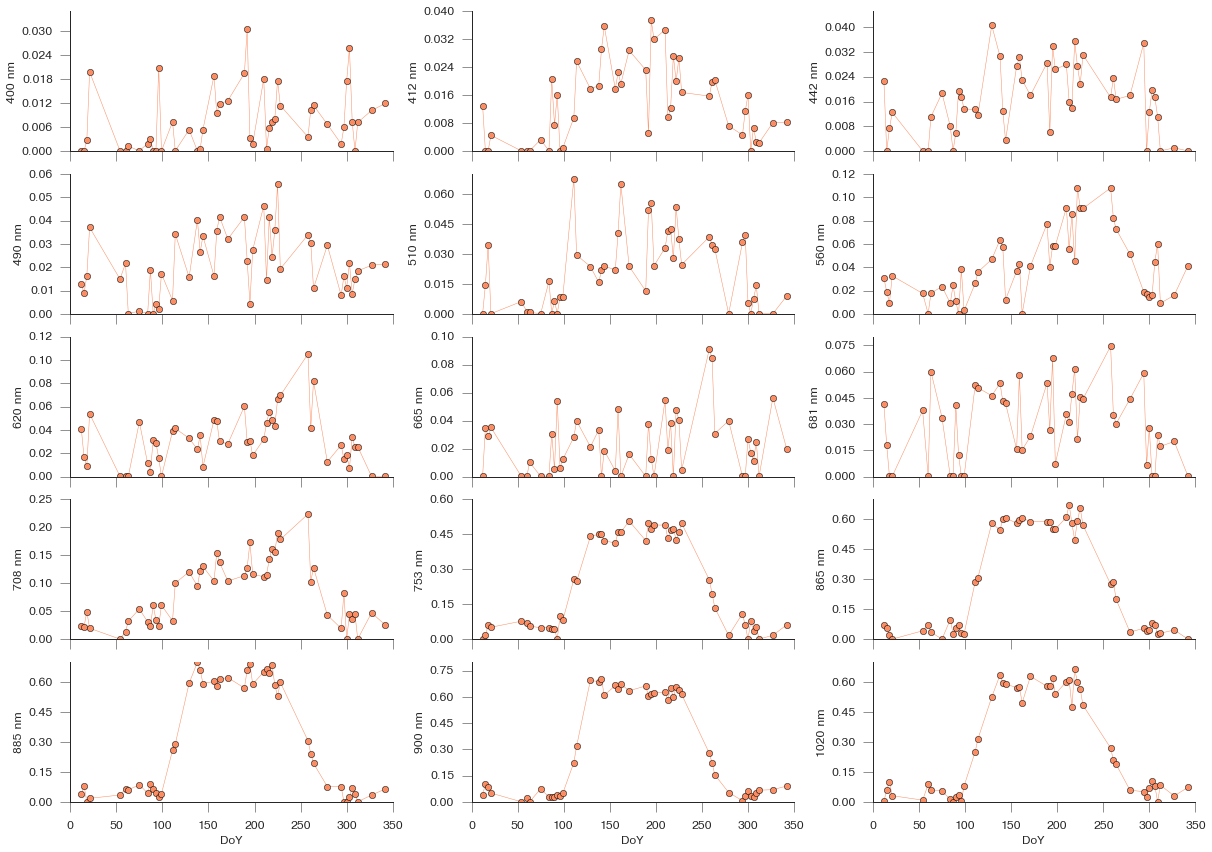

In [8]:
if do_obs and do_s3olci:
    
    olci_doys, olci_vza, olci_sza, olci_raa, olci_rho, olci_bu = create_observations2 ( 
                state, parameter_grid, "42.0", "-8:0", the_time="13:30", b_min=olci_b_min, 
                b_max = olci_b_max, every=3, prop=0.45, WINDOW=7, noise_scalar=0.9, emu_dir="./emus/"  )
    np.savetxt("olci_observations.txt", np.c_[ olci_doys, olci_vza, olci_sza, 
                                                 olci_raa, olci_rho.T],fmt="%20.10G")
    fig, axs = plt.subplots ( nrows=5, ncols=3, sharex=True, figsize=(17,12))
    axs = axs.flatten()
    for iband in xrange ( olci_n_bands ):

        axs[iband].plot ( olci_doys, olci_rho[iband, :], '-o', lw=0.5 )
        axs[iband].set_ylabel("%g nm" % olci_bh[iband])
        pretty_axes(axs[iband])
        if iband > 11:
            axs[iband].set_xlabel( "DoY")
    plt.tight_layout()
    olci_emulators = grab_emulators ( olci_vza, olci_sza, emulator_home=emu_dir )
    olci_mask = np.c_[ olci_doys, np.ones_like(olci_doys), olci_vza, olci_sza, \
                      np.zeros_like ( olci_sza)]
    olci_obs = ObservationOperatorNew( state_grid, state, olci_rho, olci_mask, \
                                      olci_emulators, olci_bu, olci_band_pass, 
                                      olci_b_max - olci_b_min )

51 (4, 51)


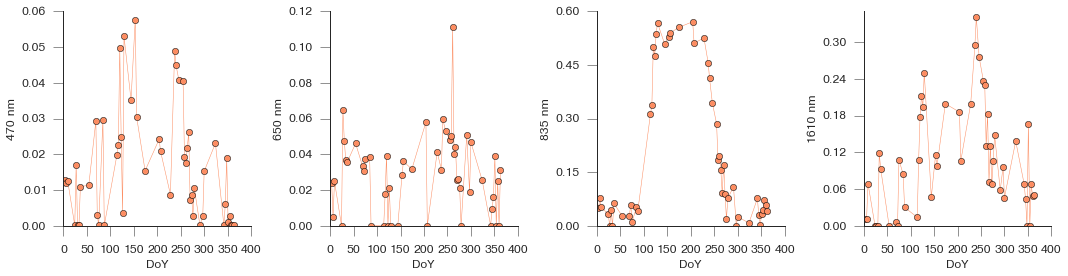

In [9]:
if do_obs and do_proba:

    proba_doys, proba_vza, proba_sza, proba_raa, proba_rho, proba_bu = create_observations2 ( 
                state, parameter_grid, "42.0", "-8:0", the_time="13:30", b_min=proba_b_min, 
                b_max = proba_b_max, every=3, prop=0.45, WINDOW=7, noise_scalar=1.4, emu_dir="./emus/"  )
    np.savetxt("proba_observations.txt", np.c_[ proba_doys, proba_vza, proba_sza, 
                                                 proba_raa, proba_rho.T],fmt="%20.10G")

    
    fig, axs = plt.subplots ( nrows=1, ncols=4, sharex=True, figsize=(15,4))
    axs = axs.flatten()
    for iband in xrange ( proba_n_bands ):

        axs[iband].plot ( proba_doys, proba_rho[iband, :], '-o', lw=0.5 )
        axs[iband].set_ylabel("%g nm" % proba_bh[iband])
        pretty_axes(axs[iband])
        axs[iband].set_xlabel( "DoY")
    plt.tight_layout()
    proba_emulators = grab_emulators ( proba_vza, proba_sza, emulator_home=emu_dir )
    proba_mask = np.c_[ proba_doys, np.ones_like(proba_doys), proba_vza, proba_sza, np.zeros_like ( proba_sza)]
    proba_obs = ObservationOperatorNew( state_grid, state, proba_rho, proba_mask, \
                                      proba_emulators, proba_bu, proba_band_pass, proba_b_max - proba_b_min )

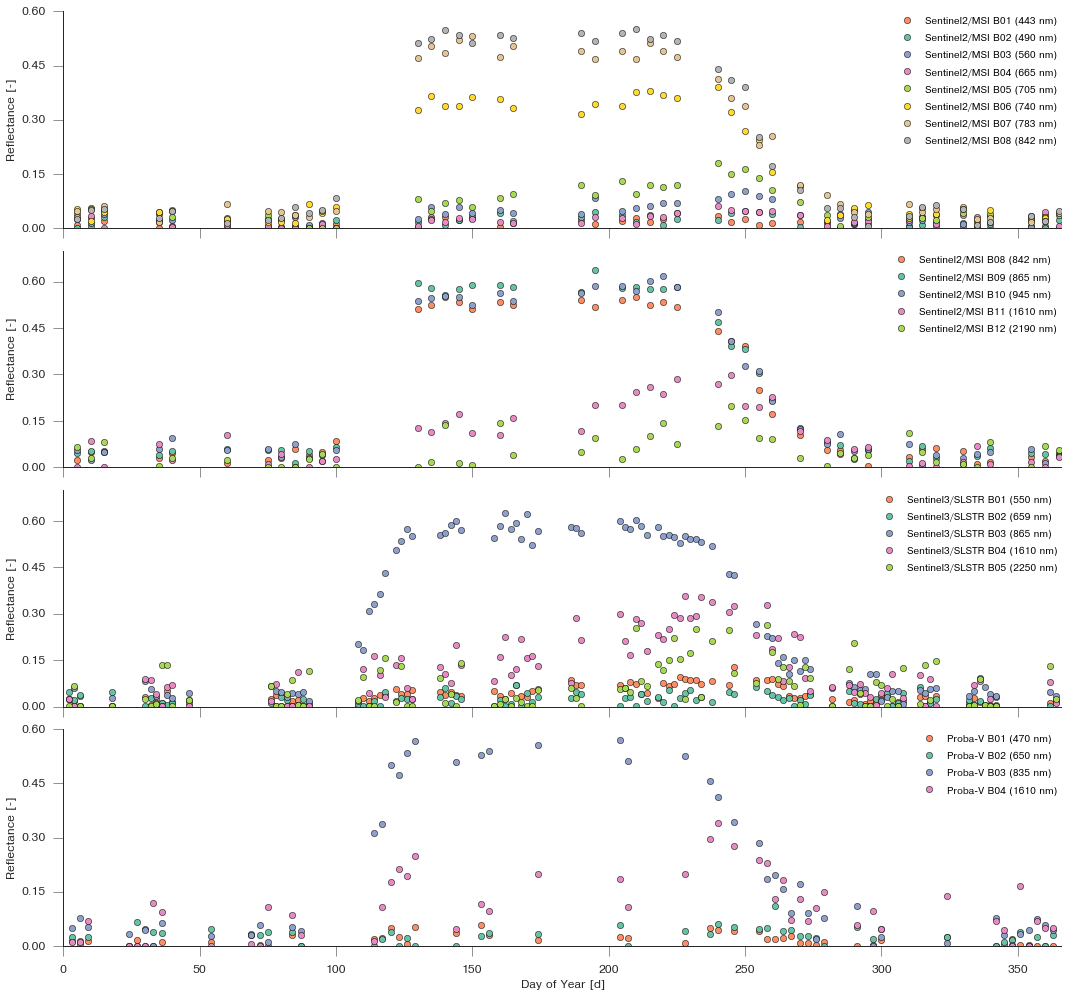

In [10]:

fig, axs = plt.subplots(nrows=4,ncols=1,sharex=True, figsize=(15,14))
for isens in xrange(4):
    if isens == 0:
        for ib in xrange(8):
            axs[0].plot(s2_doys, s2_rho[ ib, :], 'o', lw=0.5,  label="Sentinel2/MSI B%02d (%g nm)" % ( ib+1, s2_bh[ib]))
            
    elif isens == 1:
        for ib in xrange(7,12):
            axs[1].plot(s2_doys, s2_rho[ ib, :], 'o', lw=0.5,  label="Sentinel2/MSI B%02d (%g nm)" % ( ib+1, s2_bh[ib]))
    elif isens == 2:
        for ib in xrange(5):
            axs[2].plot(slstr_doys, slstr_rho[ib, :], 'o', lw=0.5,  label="Sentinel3/SLSTR B%02d (%g nm)" % ( ib+1, slstr_bh[ib]))
    elif isens == 3:
        
        for ib in xrange(4):
            axs[3].plot(proba_doys, proba_rho[ib, :], 'o',  lw=0.5, label="Proba-V B%02d (%g nm)" % ( ib+1, proba_bh[ib]))
axs[3].set_xlim ( 0, 366 )
leg = axs[0].legend(loc='best', numpoints=1, fancybox=False, shadow=False, fontsize=10, frameon=False, borderpad=0., labelspacing=0.8 )
leg = axs[1].legend(loc='best', numpoints=1, fancybox=False, shadow=False, fontsize=10, frameon=False, borderpad=0., labelspacing=0.8 )
leg = axs[2].legend(loc='best', numpoints=1, fancybox=False, shadow=False, fontsize=10, frameon=False, borderpad=0., labelspacing=0.8 )
leg = axs[3].legend(loc='best', numpoints=1, fancybox=False, shadow=False, fontsize=10, frameon=False, borderpad=0., labelspacing=0.8 )
for ax in axs:
    pretty_axes(ax)
    ax.set_ylabel("Reflectance [-]")
axs[3].set_xlabel("Day of Year [d]")
plt.tight_layout()
plt.savefig("forward_modelled_reflectances.pdf", dpi=600, bbox_inches="tight")

### Setting up the inverse problem

In a typical ``eoldas_ng`` problem, we also need to set up a **prior** as well as some simple **model**. For a prior, we will just define a fairly uninformative prior as follows:

In [11]:
mu_prior = OrderedDict ()
prior_inv_cov = OrderedDict ()
prior_inv_cov['n'] = np.array([1])
prior_inv_cov['cab'] = np.array([3])
prior_inv_cov['car'] = np.array([1])
prior_inv_cov['cbrown'] = np.array([1])
prior_inv_cov['cw'] = np.array([3])
prior_inv_cov['cm'] = np.array([1])
prior_inv_cov['lai'] = np.array([3])
prior_inv_cov['ala'] = np.array([1])
prior_inv_cov['bsoil'] = np.array([2])
prior_inv_cov['psoil'] = np.array([2])
    
for param in state.parameter_min.iterkeys():
    if state.transformation_dict.has_key ( param ):
        mu_prior[param] = state.transformation_dict[param]( \
                np.array([state.default_values[param]]) )
    else:
        mu_prior[param] = np.array([state.default_values[param]])
    prior_inv_cov[param] = 1./prior_inv_cov[param]**2
mu_prior['lai'] = 0.7788 
mu_prior['cab'] = 0.4066
mu_prior['cw'] =  0.3678
prior = Prior ( mu_prior, prior_inv_cov )

As a **model**, we will choose a first order temporal regularisation model that will be applied to the three parameters we will be trying to infer, LAI, Cab and Cw. The amount of regularisation is identical for each, and set to 25000.

In [12]:
temporal = TemporalSmoother ( state_grid, 25000, required_params=["lai", "cab", "cw"] )

At this point, we have set up the individual operators, and also the state up at the top. We need to make the state aware of the operators, set some starting point for the minimisation, and minimise away!! This is done by *adding* the operators to **``state``**. Finally, we need a starting point for our initialisation. The strategy here is to try to use a previous solution (so if you run the system a few times, you get a solution faster), or for the first time this is run, to use a random starting point, which would take more iterations to converge.

In [13]:
state.add_operator ( "Prior", prior )
state.add_operator ( "Model", temporal )

if do_s2msi:
    state.add_operator ( "S2MSI", s2_obs )
    
if do_s3olci:
    state.add_operator ( "S3OLCI", olci_obs )

if do_s3slstr:
    state.add_operator ( "S3SLSTR", slstr_obs )

if do_proba:
    state.add_operator ( "PROBAV", proba_obs )


    
x_dict = {}
#for i,k in enumerate(state.parameter_max.keys()):
#    if state.state_config[k] == VARIABLE:
#        x_dict[k] =  ( parameter_grid[i, :] )
#    else:
#        x_dict[k] = parameter_grid[i, 0]*0+ mu_prior[k]
try:
    x_dict['lai'] = retval['real_map']['lai']
    x_dict['cab'] = retval['real_map']['cab']
    x_dict['cw'] = retval['real_map']['cw']
except:
    x_dict['lai'] = np.random.rand(state_grid.shape[0])*5.#mu_prior['lai']
    x_dict['cab'] = np.random.rand(state_grid.shape[0])*70.
    x_dict['cw'] = np.random.rand(state_grid.shape[0])*0.08
    

In [14]:
retval = state.optimize ( x0=x_dict, do_unc=True)

/home/ucfajlg/.local/lib/python2.7/site-packages/eoldas_ng-0.2-py2.7.egg/eoldas_ng/state.py:305: OptimizeWarning: Unknown solver options: macor
/home/ucfajlg/.local/lib/python2.7/site-packages/eoldas_ng-0.2-py2.7.egg/eoldas_ng/state.py:369: RuntimeWarning: invalid value encountered in sqrt


We can now visualise the solution as the temporal trajectories of LAI, chlorophyll and leaf water, plus the uncertainties (e.g. the 90% posterior credible interval), as well as the truth that went into generating the original data:

In [15]:
parameter_grid = np.loadtxt("data/parameter_trajectory.txt")
fig, axs = plt.subplots(3,1,sharex=True, figsize=(15,15))
colors = ["#8DA0CB","#E78AC3", "#A6D854", "#FFD92F"]
param=['lai','cab', 'cw']
paramlist=[r'$LAI [m^{2}m^{-2}]$', '$C_{ab}[g\,cm^{-2}]$', '$C_w[cm^{-1}]$']
posns=[6,1,4]
for i,ax in enumerate(axs):
    ax.plot( state_grid, retval["real_ci5pc"][param[i]], '-k', lw=0.8)
    ax.plot( state_grid, retval["real_ci95pc"][param[i]], '-k', lw=0.8)
    ax.fill_between ( state_grid, retval["real_ci95pc"][param[i]], \
                     retval["real_ci5pc"][param[i]], facecolor="0.7", linewidth=0 )
    ax.plot ( state_grid, retval['real_map'][param[i]] , lw=3, label="DA solution")
    ax.plot ( np.arange(1,366), parameter_grid[:,posns[i]] , "--", lw=3, label="Truth")
    if do_s2msi:
        [ax.axvline(ii, c=colors[0], lw=1.5, alpha=0.5) for ii in s2_doys]
        ax.plot([],[],c=colors[0], label="S2/MSI obs")
    if do_s3slstr:
        [ax.axvline(ii, c=colors[1], lw=1.5, alpha=0.5) for ii in slstr_doys]
        ax.plot([],[],c=colors[1], label="S3/SLSTR obs")
    if do_s3olci:
        [ax.axvline(ii, c=colors[2], lw=1.5, alpha=0.5) for ii in olci_doys]
        ax.plot([],[],c=colors[2], label="S3/OLCI obs")
    if do_proba:
        [ax.axvline(ii, c=colors[3], lw=1.5, alpha=0.5) for ii in proba_doys]
        ax.plot([],[],c=colors[3], label="ProbaV obs")    
    pretty_axes(ax)
    if i == 0:
        ax.legend(loc='best', shadow=True, fancybox=True )
    ax.set_ylabel ( paramlist[i], fontsize=16 )
    if i == 2:
        ax.set_xlabel ( "DoY", fontsize=16)
plt.tight_layout()
plt.savefig("eoldas_sentinel_expt.pdf", dpi=600, bbox_inches="tight" )
plt.savefig("eoldas_sentinel_expt.png", dpi=600, bbox_inches="tight" )

IOError: [Errno 2] No such file or directory: 'data/parameter_trajectory.txt'

It is useful to see the "goodness" of fit of the maximum *a posteriori* parameter estimates to the actual data. Note that in these plots, we are not propagating the uncertainty in the parameters into the predicted reflectance, but just the MAP estimate:

In [ ]:
if do_s2msi:
    yfwd=np.array( s2_obs.fwd_modelled_obs )
    fig, axs = plt.subplots ( nrows=4, ncols=3, sharex=True, figsize=(15,10))
    axs = axs.flatten()
    for iband in xrange ( s2_n_bands ):

        axs[iband].errorbar ( s2_doys, s2_rho[iband, :], 
                                 yerr=np.ones_like(s2_doys)*s2_bu[iband], fmt="o" )
        axs[iband].plot ( s2_doys, yfwd[:,iband], '-')
        axs[iband].set_ylabel("%g nm" % s2_bh[iband])
        pretty_axes(axs[iband])
        if iband > 8:
            axs[iband].set_xlabel( "DoY")
    plt.tight_layout()

In [ ]:
if do_s3slstr:
    yfwd=np.array( slstr_obs.fwd_modelled_obs )
    fig, axs = plt.subplots ( nrows=1, ncols=5, sharex=True, figsize=(16,4))
    axs = axs.flatten()
    for iband in xrange ( slstr_n_bands ):

        axs[iband].errorbar ( slstr_doys, slstr_rho[iband, :], 
                                 yerr=np.ones_like(slstr_doys)*slstr_bu[iband], fmt="o" )
        axs[iband].plot ( slstr_doys, yfwd[:,iband], '-')
        axs[iband].set_ylabel("%g nm" % slstr_bh[iband])
        
        axs[iband].set_xlabel( "DoY")
        pretty_axes(axs[iband])
        
    plt.tight_layout()

In [ ]:
if do_s3olci:
    yfwd=np.array( olci_obs.fwd_modelled_obs )
    fig, axs = plt.subplots ( nrows=5, ncols=3, sharex=True, figsize=(15,12))
    axs = axs.flatten()
    for iband in xrange ( olci_n_bands ):

        axs[iband].errorbar ( olci_doys, olci_rho[iband, :], 
                                 yerr=np.ones_like(olci_doys)*olci_bu[iband], fmt="o" )
        axs[iband].plot ( olci_doys, yfwd[:,iband], '-')
        axs[iband].set_ylabel("%g nm" % olci_bh[iband])
        
        pretty_axes(axs[iband])
        if iband > 11:
            axs[iband].set_xlabel( "DoY")
    plt.tight_layout()

In [ ]:
if do_proba:
    yfwd=np.array( proba_obs.fwd_modelled_obs )
    fig, axs = plt.subplots ( nrows=1, ncols=4, sharex=True, figsize=(15,4))
    axs = axs.flatten()
    for iband in xrange ( proba_n_bands ):

        axs[iband].errorbar ( proba_doys, proba_rho[iband, :], 
                                 yerr=np.ones_like(proba_doys)*proba_bu[iband], fmt="o" )
        axs[iband].plot ( proba_doys, yfwd[:,iband], '-')
        axs[iband].set_ylabel("%g nm" % proba_bh[iband])
        
        pretty_axes(axs[iband])
        axs[iband].set_xlabel( "DoY")
    plt.tight_layout()

### Comparing the retrievals to single observation retrievals

The use of regularisation leads to a very powerful ability to both interpolate over data gaps, but also to transfer information in time. A (mostly fair) comparison would be to test retrievals that have not used regularisation (i.e., the typical single observation inversion scenario, where a prior is used to provide a modicum of regularisation). We will implement this strategy with ``eoldas_ng``. To simplify the code, we will use all the available observations, and the system will actually combine in the inversion all observations that fall on the same day.

In [ ]:
state_noda =  StandardStatePROSAIL ( state_config, state_grid, 
                               optimisation_options=optimisation_options )
state_noda.add_operator ( "Prior", prior )
if do_s2msi:
    state_noda.add_operator ( "S2MSI", s2_obs )
if do_s3slstr:
    state_noda.add_operator ( "S3SLSTR", slstr_obs )
if do_s3olci:
    state_noda.add_operator ( "S3OLCI", olci_obs )
if do_proba:
    state_noda.add_operator ( "PROBA", proba_obs )
    
retval_noDA = state_noda.optimize ( x0=x_dict, do_unc=True )

We will now plot the results. Note that this plot is a bit misleading! Bear in mind that ``eoldas_ng`` would provide with an estimate of the state even when no observations and no temporal model is available, by simply reverting the state to the prior mean (and using the prior distribution to report uncertainty). So in practice, we would only get estimates where we have observations. Notice the large uncertainties, essentially informing us that the potential value of the parameter is widely spread over a large region, and in this case, the maximum *a posteriori* estimate is not to be trusted. You can also see that this estimate diverges from the truth.

In [ ]:
fig, axs = plt.subplots(3,1,sharex=True, figsize=(15,15))
colors = ["#8DA0CB","#E78AC3", "#A6D854", "#FFD92F"]
param=['lai', 'cab', 'cw']
posns=[6,1,4]
for i,ax in enumerate(axs):
    ax.plot( state_grid, retval_noDA["real_ci5pc"][param[i]], '-k', lw=0.8)
    ax.plot( state_grid, retval_noDA["real_ci95pc"][param[i]], '-k', lw=0.8)
    ax.fill_between ( state_grid, retval_noDA["real_ci95pc"][param[i]], \
                     retval_noDA["real_ci5pc"][param[i]], facecolor="0.7", linewidth=0 )
    ax.plot ( state_grid, retval_noDA['real_map'][param[i]] , lw=3, label="eoldas solution")
    ax.plot ( np.arange(1,366), parameter_grid[:, posns[i]] , "--", lw=4, label="Truth")
    
    
    ax.set_ylabel ( paramlist[i], fontsize=16 )
    if i == 2:
        ax.set_xlabel ( "DoY", fontsize=16)
    if i == 0:
        ax.legend(loc='best', shadow=True, fancybox=True )
    pretty_axes(ax)

In [ ]:
from IPython.core.display import HTML
import urllib2
def css_styling():
    styles = open( "custom.css", 'r').read()
    return HTML(styles)
css_styling()